In [0]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [0]:
import os
import numpy as np
import tensorflow as tf
import keras
import keras.metrics
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['axes.labelcolor'] = 'black'
plt.rcParams['xtick.color'] = 'black'
plt.rcParams['ytick.color'] = 'black'
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from keras.utils import to_categorical
#from keras.models import load_model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping
from scipy import ndimage
from sklearn.metrics import confusion_matrix
import h5py

In [0]:
class ParticleClassifier():
    def __init__(self):
        '''x and y is after preprocessing'''
        self.path = None
        self.images = None
        self.labels = None
        self.images_train = None
        self.images_test = None
        self.labels_train = None
        self.labels_test = None
        self.x = None
        self.y = None
        self.x_train = None
        self.x_test = None
        self.y_train = None
        self.y_test = None
        self.images_attacked = None
        self.labels_attacked = None
        self.x_attacked = None
        self.y_attacked = None
        self.predictions = None
        self.attacked_predictions = None
        self.misclassifications = None
        self.images_mis_orig = None
        self.images_mis_attacked = None
        self.pred_mis_orig = None
        self.pred_mis_attacked = None
        self.report_dict = None
        
        self.model = tf.keras.models.Sequential([
        # Note the input shape is the desired size of the image 50x50 with 1 bytes color
        tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(50, 50, 1)),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(16, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Flatten(),
        # 512 neuron hidden layer
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(3, activation='softmax')
        ])
        
        self.messages = {'load_data': 'Data loaded into self.images, self.labels',
                         'train_test_split': 'Split into self.images_train, self.images_test, self.labels_train, self.labels_test',
                         'pre_proc_train': 'Train images pre-processed into self.x_train',
                         'pre_proc_test': 'Test images pre-processed into self.x_test',
                         'one_hot_encode': 'Train and test labels encoded into self.y_train and self.y_test',
                         'train_model': 'Model trained.',
                         'gen_hot_channel_data': 'Hot channel data generated in self.images_attacked, self.labels_attacked, self.x_attacked, self.y_attacked'}
            
        
    def __call__(self):
        return
        
    def load_data(self, path='data/toy_data.csv'):
        '''Loads data from path into self.labels and self.images'''
        self.path = path
        data = np.genfromtxt(path, delimiter=',')
        self.labels = data[:,0].astype(int)
        self.images = data[:, 1:].reshape((len(data),50,50,1))
        print(self.messages['load_data'])
        return self
    
    def train_test_split(self, images=None, labels=None, test_size=0.2):
        '''Wrapper around train_test_split'''
        if images is None:
            images = self.images
        if labels is None:
            labels = self.labels
        self.images_train, self.images_test, self.labels_train, self.labels_test = \
        train_test_split(images, labels, test_size=test_size)
        print(self.messages['train_test_split'])
        return self
        
    def pre_proc_filter(self, images, size=2, sigma=2):
        '''Applies Median filter and Gaussian filter to remove noise and hot
        channels. Size refers to size of Median filter, sigma refers to Gaussian
        filter parameter - larger for more blurring.
        Parameters
        ----------
        size: int, optional 
        sigma: int, optional
        '''
        orig_shape = images.shape
        images_new = []
        for image in images.reshape((images.shape[0:-1])):        
            image_new = ndimage.median_filter(image, size=size, mode='wrap')
            image_new = ndimage.gaussian_filter(image_new, sigma=sigma)
            images_new.append(image_new)
        return np.array(images_new).reshape(orig_shape)
    
    def pre_proc_rescale(self, images, negative=False):
        '''Subtract the mean, scales all image to between -1 and 1, and remove
        all negative values (if False).
        '''
        orig_shape = images.shape
        images_reshaped = images.reshape((orig_shape[0], -1))
        images_scaled = np.subtract(images_reshaped, np.median(images_reshaped, axis=1, keepdims=True))
        if not negative:
            images_scaled[images_scaled < 0] = 0.
        images_scaled = np.divide(images_scaled, np.max(images_scaled, axis=1, keepdims=True))
        images_scaled = images_scaled.reshape(orig_shape)
        return images_scaled
    
    def pre_proc(self, images, size=2, sigma=2, filters=False, rescale=True):
        '''Helper function that removes applies pre-processing to givem images.
        '''
        x = images.copy()
        if filters:
            x = self.pre_proc_filter(x, size=size, sigma=sigma)
        if rescale:
            x = self.pre_proc_rescale(x)
        return x
    
    def pre_proc_images(self, filters=False, rescale=True, 
                        train=False, test=False, attacked=False, size=2, sigma=2):
        '''Pre-processes any of the 3 image sets (train, test, attacked).
        Filters indicate if Median and Gaussian filters should be applied. 
        Rescale indicate if images should be rescaled.'''
        if train:
            self.x_train = self.pre_proc(self.images_train, size=size, 
                                         sigma=sigma, filters=filters, 
                                         rescale=rescale)
        if test:
            self.x_test = self.pre_proc(self.images_test, size=size, sigma=sigma,
                                        filters=filters, rescale=rescale)
        if attacked:
            self.x_attacked = self.pre_proc(self.images_attacked, size=size,
                                            sigma=sigma, filters=filters, 
                                            rescale=rescale)
        return self
    
    def one_hot_encode_labels(self, train=False, test=False, attacked=False):
        '''One hot encodes any of the 3 label sets (train, test, attacked).'''
        if train:
            self.y_train = to_categorical(self.labels_train)
        if test:
            self.y_test = to_categorical(self.labels_test)
        if attacked:
            self.y_attacked = to_categorical(self.labels_attacked)
        #print(self.messages['one_hot_encode'])
        return self

        
    def train_model(self, x=None, y=None, val_split=0.2, epochs=10, verbose=1,
                    callback=None, min_delta=0.02, patience=5):
        '''Trains CNN model.'''
        if x is None:
            x = self.x_train
        if y is None:
            y = self.y_train
        if callback is None:
            self.callback = EarlyStopping(monitor='val_loss',
                                      min_delta=min_delta,
                                      patience=patience)
            
        self.model.compile(loss='categorical_crossentropy',
                          optimizer='adam',
                          metrics=['acc'])
        
        self.model.fit(x,
                      y,  
                      epochs=epochs,
                      verbose=verbose,
                      validation_split=val_split,
                      callbacks=[self.callback])
        print(self.messages['train_model'])
        return self
    
    def save_model(self, name):
        self.model.save(name)
        return self
        
    def load_model(self, name):
        self.model = tf.keras.models.load_model(name)
        return self
    
    def evaluate_model(self, x_test=None, y_test=None):
        '''Evaluate model against test set'''
        if x_test is None:
            x_test = self.x_test
        if y_test is None:
            y_test = self.y_test
        self.model.evaluate(x_test, y_test)
        y_pred = self.model.predict(x_test)
        #print(classification_report(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1)))
        return self
    
    def gen_hot_channel_data(self, images=None, labels=None, value=None):
        '''Adds a hot channel with double the max value at a random location 
        for each image.'''
        change_self = False
        if images is None:
            images = self.images_test
            change_self = True
        if labels is None:
            labels = self.labels_test
        if value is None:
            value = np.max(images) * 2
        loc = np.random.randint(0, images.shape[2], size=(images.shape[0], 2))
        images_edited = images.copy()
        images_edited[np.arange(images.shape[0]),loc[:,0], loc[:,1]] = value
        self.images_attacked = images_edited
        self.x_attacked = self.pre_proc(self.images_attacked)
        self.labels_attacked = labels
        self.y_attacked = self.one_hot_encode_labels(labels)
        print(self.messages['gen_hot_channel_data'])
        return self
    
    def evaluate_attack(self, x=None, x_attacked=None, labels=None, labels_attacked=None, 
                        table=True, confusion_matrix=True, file_name=False):
        '''Evaluates the 
        against predictions without attack. Test data is used by default'''
        if x is None:
            x = self.x_test
            x_attacked = self.x_attacked
            images = self.images_test
            images_attacked = self.images_attacked
            labels = self.labels_test
            labels_attacked = self.labels_attacked
        original_pred = np.argmax(self.model.predict(x), axis=1).astype(int)
        attacked_pred = np.argmax(self.model.predict(x_attacked), axis=1).astype(int)
        self.predictions = original_pred
        self.attacked_predictions = attacked_pred
        self.misclassifications = np.invert(np.equal(original_pred, attacked_pred))
        self.images_mis_orig = images[self.misclassifications]
        self.images_mis_attacked = images_attacked[self.misclassifications]
        self.pred_mis_orig = original_pred[self.misclassifications]
        self.pred_mis_attacked = attacked_pred[self.misclassifications]
        if table:
            print('Labels: {} \n Original Predictions: {} \n Attacked Predictions: {}'\
                  .format(np.bincount(labels_attacked), np.bincount(original_pred),
                          np.bincount(attacked_pred)))
            print(classification_report(original_pred, attacked_pred)) 
        if confusion_matrix:
            correct_classifications = np.equal(labels, original_pred)
            self.generate_confusion_matrix(correct_classifications, file_name)
        self.report_dict = classification_report(original_pred, attacked_pred, 
                                                 output_dict=1)
        return self
    
    def apply_attack(self, attack, images=None, labels=None, gaussian_noise=True, **kwargs):
        '''Update images_attacked and labels_attacked after applying attack
        on an image set (test by default). '''
        if images is None:
            images = self.images_test
        if labels is None:
            labels = self.labels_test
        images_edited = images.copy()
        images_edited = attack(images_edited, **kwargs)
        if gaussian_noise:
            images_edited = self.add_gaussian_noise(images_edited, 50,  3)
        self.images_attacked = images_edited
        self.labels_attacked = labels
        return self
    
    def add_gaussian_noise(self, images, mu, sigma):
        '''Adds Gaussian noise for a given image, with mean = mu and standard
        deviation = sigma.
        :param images (n, x, y, 1)
        :param mu float
        :param sigma float'''
        gauss = np.random.normal(mu, sigma, size=images.shape)
        return images.copy() + gauss

    def add_sp_noise(self, images, ratio, prob):
        '''Adds salt & pepper noise for a given image, with a ratio between salt
        and pepper = ratio, and probability of noise = prob
        :param images (n, x, y, 1)
        :param ratio float
        :param prob float'''
        noisy = np.copy(images)
        salt = np.ceil(prob * ratio * noisy[0].size)
        pepper = np.ceil(prob * (1-ratio) * noisy[0].size)

        for i in range(int(salt)):
          loc = np.random.randint(0, noisy.shape[2], size=(noisy.shape[0], 2))
          noisy[np.arange(noisy.shape[0]),loc[:,0], loc[:,1]] = noisy.max()
          
        for j in range(int(pepper)):
          loc = np.random.randint(0, noisy.shape[2], size=(noisy.shape[0], 2))
          noisy[np.arange(noisy.shape[0]),loc[:,0], loc[:,1]] = 0
        return noisy

    def add_poisson_noise(self, images, lambd):
        '''Adds Poisson noise for a given image
        :param images (n, x, y, 1)
        :param lambda float'''
        poiss = np.random.poisson(lambd, size=images.shape)
        images = poiss + images
        return images
    
    def signal_to_noise(self, images, ratio=1.):
        '''Allows the signal to noise ratio to be varied for a given image
        :param images (n, x, y, 1)
        :param ratio float'''
        images = (images - np.min(images)) * ratio + np.min(images)
        return images 
        
    def add_hot_area(self, images, size, value=None, pos=None):
        '''Adds a hot channel at a given location pos=(x, y) with 
        size (i, j) for a given image.
        :param images (n, x, y, 1)
        :param pos (x, y), x and y are arrays of length n
        :param size (i, j)
        :param value to be replaced'''
        images_att = images.copy()
        if pos is None:
            x = np.random.randint(0, images.shape[1]-size[0],
                                  size=(images.shape[0],1))
            y = np.random.randint(0, images.shape[2]-size[1], 
                                  size=(images.shape[0], 1))
            pos = np.concatenate([x, y], axis=1)
        if value is None:
            value = images.max()
        for i in range(size[0]):
            for j in range(size[1]):
                images_att[np.arange(images_att.shape[0]), pos[:,0]+i, 
                           pos[:,1]+j, 0] = value
        return images_att
    
    def hot_pixel_attack(self, images=None, labels=None, value=None):
        if images is None:
            images = self.images_test
        if labels is None:
            labels = self.labels_test
        if value is None:
            value = np.max(images) * 2
            
        loc = np.random.randint(0, images.shape[2], size=(images.shape[0], 2))
        self.apply_attack(self.add_hot_area, images, labels, gaussian_noise=False,
                          size=[1,1], value=value, pos=loc)
        return self
        
    
    def print_image(self, index, image_set, file_name=False):
        '''Shows the nth image of an 4d image set of n images: (n, height, length, channel)'''
        if type(image_set) is not list:
            image_set = [image_set]
        for images in image_set:
            plt.imshow(images[index,:,:,0])
            plt.colorbar()
            if file_name:
                plt.savefig(file_name, bbox_inches='tight')
            plt.show()
        return self
        
    def show_misclassified_images(self, index, file_name=False):
         for i in index:
             if file_name:
                org = '_orig.'.join(file_name.split('.'))
                atk = '_attacked.'.join(file_name.split('.'))
             else:
                org = False
                atk = False
             self.print_image(i, self.images_mis_orig, 
                              file_name=org)
             self.print_image(i, self.images_mis_attacked, 
                             file_name=atk)
             print('{}, {}'.format(self.pred_mis_orig[i],
                                   self.pred_mis_attacked[i]))
         return self
     
    def generate_confusion_matrix(self, index, savefig):
        labels = ['background', 'electron', 'muon']
        cm = confusion_matrix(self.predictions[index],
                              self.attacked_predictions[index]).astype(np.float)
        for i in range(len(cm)):
            cm[i,:] = cm[i,:]/cm[i,:].sum()
        plt.rcParams.update({'axes.labelsize': 12,
                             'axes.labelcolor': 'gray',
                             'xtick.color': 'gray',
                             'ytick.color': 'gray',
                             'xtick.labelsize': 12,
                             'ytick.labelsize': 12})
        fig, ax = plt.subplots()
        im = ax.imshow(cm, cmap='summer')
        ax.tick_params(top=True, bottom=False, labeltop=True, labelbottom=False)
        ax.set_xlabel('After Attack')
        ax.set_ylabel('Before Attack')
        ax.set_xticks(np.arange(3))
        ax.set_yticks(np.arange(3))
        ax.set_xticklabels(labels)
        ax.set_yticklabels(labels)
        ax.set_xticks(np.arange(3)-0.5, minor=True)
        ax.set_yticks(np.arange(3)-0.5, minor=True)
        
        for i in range(len(cm)):
            for j in range(len(cm[0])):
                text = ax.text(j, i, '%.3f'%cm[i, j], ha='center', 
                               va='center', color='black', size=15)
        ax.grid(which="minor", color="black", linestyle='-', linewidth=4)
        fig.tight_layout()
        if savefig:
            plt.savefig(savefig)
        else:
            plt.show()

In [56]:
path = '/content/drive/My Drive/Year 3/BSc Project/toy_data.csv'
classifier = ParticleClassifier()\
                .load_data(path)\
                .train_test_split()\
                .pre_proc_images(train=True, test=True)\
                .one_hot_encode_labels(train=True, test=True)\
                .train_model()\
                .evaluate_model()\

Data loaded into self.images, self.labels
Split into self.images_train, self.images_test, self.labels_train, self.labels_test
Train on 1920 samples, validate on 480 samples
Epoch 1/10
1920/1920 [==============================] - 8s 4ms/sample - loss: 0.6285 - acc: 0.7078 - val_loss: 0.6494 - val_acc: 0.7917
Epoch 2/10
1920/1920 [==============================] - 8s 4ms/sample - loss: 0.3334 - acc: 0.8797 - val_loss: 0.2992 - val_acc: 0.8896
Epoch 3/10
1920/1920 [==============================] - 8s 4ms/sample - loss: 0.3308 - acc: 0.8646 - val_loss: 0.2502 - val_acc: 0.9125
Epoch 4/10
1920/1920 [==============================] - 8s 4ms/sample - loss: 0.2304 - acc: 0.9120 - val_loss: 0.1811 - val_acc: 0.9312
Epoch 5/10
1920/1920 [==============================] - 8s 4ms/sample - loss: 0.1828 - acc: 0.9344 - val_loss: 0.2013 - val_acc: 0.9125
Epoch 6/10
1920/1920 [==============================] - 8s 4ms/sample - loss: 0.1864 - acc: 0.9323 - val_loss: 0.1388 - val_acc: 0.9521
Epoch 7/10


Gaussian noise

In [0]:
def plots(x, report_list, x_label):

  acc_list = []
  for i in report_list:
    acc_list.append(i['accuracy'])
  plt.plot(x, acc_list, '--x')
  plt.plot(0, 0.9650, 'ro', label = 'No Attack')
  plt.title('Accuracy')
  plt.ylabel("Accuracy")
  plt.xlabel(x_label)
  plt.legend()
  plt.show()
  
  # plotting f_1 scores
  f_list_0 = []
  f_list_1 = []
  f_list_2 = []
  for i in report_list:
    f_list_0.append(i['0']['f1-score'])
    f_list_1.append(i['1']['f1-score'])
    f_list_2.append(i['2']['f1-score'])

  plt.plot(x, f_list_0, '--x',label = 'background')
  plt.plot(x, f_list_1, '--x', label = 'electron')
  plt.plot(x, f_list_2,'--x', label = 'muon')
  plt.title('f1 score')
  plt.ylabel("f1 score")
  plt.xlabel(x_label)
  plt.legend()
  plt.show()

  # plotting precision
  p_list_0 = []
  p_list_1 = []
  p_list_2 = []
  for i in report_list:
    p_list_0.append(i['0']['precision'])
    p_list_1.append(i['1']['precision'])
    p_list_2.append(i['2']['precision'])

  plt.plot(x, p_list_0 ,'--x',label = 'background')
  plt.plot(x, p_list_1,'--x', label = 'electron')
  plt.plot(x, p_list_2,'--x', label = 'muon')

  plt.title('Precision')
  plt.ylabel("Precision")
  plt.xlabel(x_label)
  plt.legend()
  plt.show()

  # plotting recall
  r_list_0 = []
  r_list_1 = []
  r_list_2 = []
  for i in report_list:
    r_list_0.append(i['0']['recall'])
    r_list_1.append(i['1']['recall'])
    r_list_2.append(i['2']['recall'])

  plt.plot(x, r_list_0 ,'--x',label = 'background')
  plt.plot(x, r_list_1,'--x', label = 'electron')
  plt.plot(x, r_list_2,'--x', label = 'muon')

  plt.title('Recall')
  plt.ylabel("Recall")
  plt.xlabel(x_label)
  plt.legend()
  plt.show()

In [57]:
s_list = [1, 3, 5, 7, 10, 15, 20, 25, 30, 40, 50, 70, 100]
report_list = []
for i in range(len(s_list)):
  classifier.apply_attack(classifier.add_gaussian_noise, mu=0, sigma=s_list[i])\
                                    .pre_proc_images(attacked=True)\
                                    .one_hot_encode_labels(attacked=True)\
                                    .evaluate_attack(table=False, confusion_matrix=False)

  report_list.append(classifier.report_dict)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


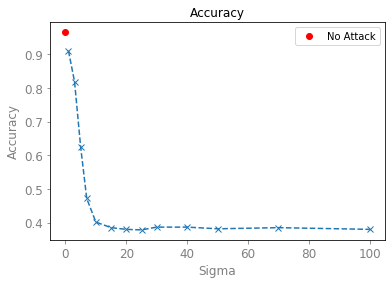

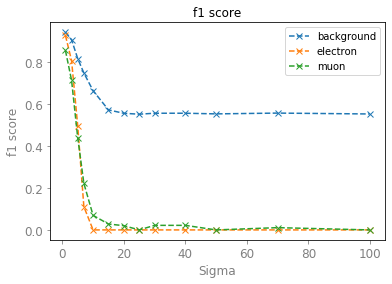

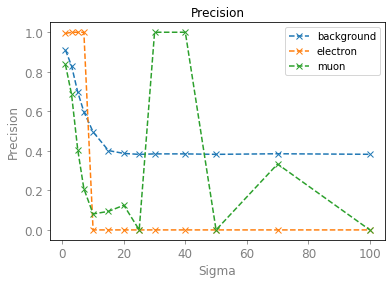

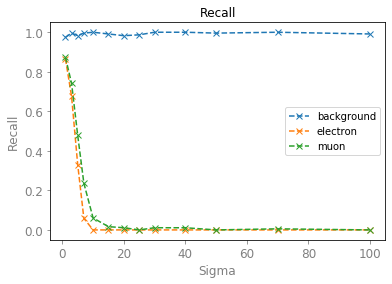

In [58]:
plots(s_list, report_list, x_label = 'Sigma')

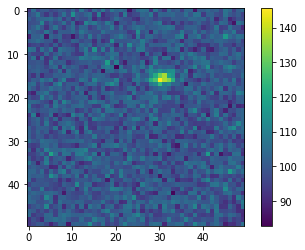

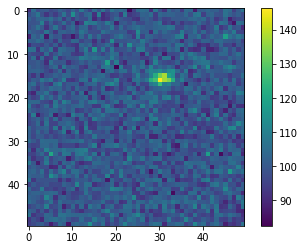

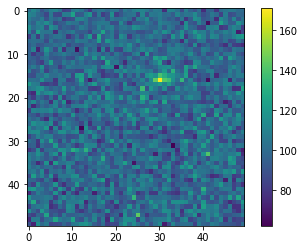

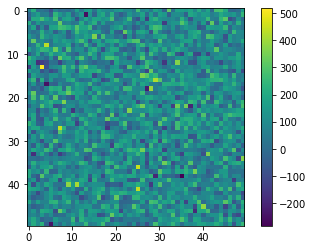

In [0]:
images = classifier.images
n = 200
plt.imshow(images[n,:,:,0])
plt.colorbar()
plt.show()
for i in [1, 10, 100]:
    gauss = np.random.normal(0, i, size=images.shape)
    noisy = images.copy() + gauss
    plt.imshow(noisy[n,:,:,0])
    plt.colorbar()
    plt.show()

In [0]:
sigmas = np.linspace(0, 100, 10)
old_preds = []
new_preds = []
muon_cutoffs = []
elec_cutoffs = []

def mb_cutoff(preds):
  if 2 in preds:
    m_b = 0
    b_m = 0
    for i in range(len(preds)):
      if preds[i] == 0 and preds[i-1] == 2:
        m_b = sigmas[i]
    for j in range(len(preds)-1, -1, -1):
      if preds[j] == 2 and preds[j-1] == 0:
        b_m = sigmas[j]
    return 0.5*(m_b + b_m)
  else:
    return

def em_cutoff(preds):
  if 1 in preds:
    e_m = 0
    m_e = 0
    for i in range(len(preds)):
      if preds[i] == 1 and preds[i-1] == 2:
        e_m = sigmas[i]
    for j in range(len(preds)-1, -1, -1):
      if preds[j] == 2 and preds[j-1] == 1:
        m_e = sigmas[j]
    return 0.5*(e_m + m_e)
  else:
    return

images = classifier.x_test

for n in range(0, 10):
  old_preds = []
  new_preds = []
  for k in range(len(sigmas)):
      sigma = sigmas[k]
      gauss = np.random.normal(0, sigma, size=images.shape)
      noisy = images.copy() + gauss

      old_pred = np.argmax(classifier.model.predict(images[n].reshape((1, 50, 50, 1))))
      old_preds.append(old_pred)

      plt.title(sigma)
      plt.imshow(img_copy[:,:,0])
      plt.colorbar()
      plt.show()

      new_pred = np.argmax(classifier.model.predict(noisy[n].reshape((1, 50, 50, 1))))
      new_preds.append(new_pred)

  if old_pred == 2:
    if mb_cutoff(new_preds) != None:
      muon_cutoffs.append(mb_cutoff(new_preds))
    if em_cutoff(new_preds) != None:
      muon_cutoffs.append(em_cutoff(new_preds))

  if old_pred == 1:
    if mb_cutoff(new_preds) != None:
      elec_cutoffs.append(mb_cutoff(new_preds))
    if em_cutoff(new_preds) != None:
      elec_cutoffs.append(em_cutoff(new_preds))

  print("muon-background:", mb_cutoff(new_preds))
  print("electron-muon:", em_cutoff(new_preds))
  plt.plot(sigmas, new_preds, '.--',color='b', label='new')
  plt.plot(sigmas, old_preds, color='orange', label='orig')
  plt.legend()
  plt.xlabel('Probability of noise')
  plt.ylabel('Prediction')
  plt.show()

In [0]:
mu = 0
sigma = 1
classifier = ParticleClassifier()\
                .load_data(path)\
                .train_test_split()\
                .pre_proc_images(train=True, test=True, filters=False)\
                .one_hot_encode_labels(train=True, test=True)\
                .train_model()\
                .evaluate_model()\
                .apply_attack(classifier.add_gaussian_noise, mu=mu, sigma=sigma)\
               .pre_proc_images(attacked=True, filters=False)\
               .one_hot_encode_labels(attacked=True)\
               .evaluate_attack()

Data loaded into self.images, self.labels
Split into self.images_train, self.images_test, self.labels_train, self.labels_test
Train and test labels encoded into self.y_train and self.y_test
Train on 1920 samples, validate on 480 samples
Epoch 1/10
1920/1920 [==============================] - 8s 4ms/sample - loss: 0.7758 - acc: 0.5797 - val_loss: 0.3829 - val_acc: 0.8396
Epoch 2/10
1920/1920 [==============================] - 8s 4ms/sample - loss: 0.3153 - acc: 0.8797 - val_loss: 0.2684 - val_acc: 0.9042
Epoch 3/10
1920/1920 [==============================] - 8s 4ms/sample - loss: 0.2603 - acc: 0.9047 - val_loss: 0.2896 - val_acc: 0.8917
Epoch 4/10
1920/1920 [==============================] - 8s 4ms/sample - loss: 0.2397 - acc: 0.9068 - val_loss: 0.2535 - val_acc: 0.9083
Epoch 5/10
1920/1920 [==============================] - 8s 4ms/sample - loss: 0.2451 - acc: 0.9078 - val_loss: 0.3226 - val_acc: 0.8792
Epoch 6/10
1920/1920 [==============================] - 8s 4ms/sample - loss: 0.190

In [0]:
mu = 0
sigma = 10
classifier = ParticleClassifier()\
                .load_data('toy_data.csv')\
                .train_test_split()\
                .pre_proc_images(train=True, test=True, filters=False)\
                .one_hot_encode_labels(train=True, test=True)\
                .train_model()\
                .evaluate_model()\
                .apply_attack(classifier.add_gaussian_noise, mu=mu, sigma=sigma)\
               .pre_proc_images(attacked=True, filters=False)\
               .one_hot_encode_labels(attacked=True)\
               .evaluate_attack()

Data loaded into self.images, self.labels
Split into self.images_train, self.images_test, self.labels_train, self.labels_test
Train and test labels encoded into self.y_train and self.y_test
Train on 1920 samples, validate on 480 samples
Epoch 1/10
1920/1920 [==============================] - 9s 4ms/sample - loss: 0.7219 - acc: 0.6260 - val_loss: 0.2399 - val_acc: 0.9000
Epoch 2/10
1920/1920 [==============================] - 8s 4ms/sample - loss: 0.2818 - acc: 0.8911 - val_loss: 0.2339 - val_acc: 0.9104
Epoch 3/10
1920/1920 [==============================] - 8s 4ms/sample - loss: 0.2224 - acc: 0.9089 - val_loss: 0.2116 - val_acc: 0.9250
Epoch 4/10
1920/1920 [==============================] - 8s 4ms/sample - loss: 0.2254 - acc: 0.9208 - val_loss: 0.1993 - val_acc: 0.9312
Epoch 5/10
1920/1920 [==============================] - 8s 4ms/sample - loss: 0.1688 - acc: 0.9411 - val_loss: 0.1708 - val_acc: 0.9417
Epoch 6/10
1920/1920 [==============================] - 8s 4ms/sample - loss: 0.139

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [0]:
mu = 0
sigma = 100
classifier = ParticleClassifier()\
                .load_data('toy_data.csv')\
                .train_test_split()\
                .pre_proc_images(train=True, test=True, filters=False)\
                .one_hot_encode_labels(train=True, test=True)\
                .train_model()\
                .evaluate_model()\
                .apply_attack(classifier.add_gaussian_noise, mu=mu, sigma=sigma)\
               .pre_proc_images(attacked=True, filters=False)\
               .one_hot_encode_labels(attacked=True)\
               .evaluate_attack()

Data loaded into self.images, self.labels
Split into self.images_train, self.images_test, self.labels_train, self.labels_test
Train and test labels encoded into self.y_train and self.y_test
Train on 1920 samples, validate on 480 samples
Epoch 1/10
1920/1920 [==============================] - 8s 4ms/sample - loss: 0.6612 - acc: 0.6807 - val_loss: 0.3130 - val_acc: 0.8604
Epoch 2/10
1920/1920 [==============================] - 8s 4ms/sample - loss: 0.2687 - acc: 0.8974 - val_loss: 0.3265 - val_acc: 0.8604
Epoch 3/10
1920/1920 [==============================] - 8s 4ms/sample - loss: 0.2643 - acc: 0.8943 - val_loss: 0.2192 - val_acc: 0.9250
Epoch 4/10
1920/1920 [==============================] - 8s 4ms/sample - loss: 0.1981 - acc: 0.9260 - val_loss: 0.1747 - val_acc: 0.9375
Epoch 5/10
1920/1920 [==============================] - 8s 4ms/sample - loss: 0.1682 - acc: 0.9448 - val_loss: 0.1943 - val_acc: 0.9208
Epoch 6/10
1920/1920 [==============================] - 8s 4ms/sample - loss: 0.129

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Salt & pepper noise

In [0]:
ratio = 0.5
prob = 0.0001
classifier = ParticleClassifier()\
                .load_data('toy_data.csv')\
                .train_test_split()\
                .pre_proc_images(train=True, test=True, filters=False)\
                .one_hot_encode_labels(train=True, test=True)\
                .train_model()\
                .evaluate_model()\
                .apply_attack(classifier.add_sp_noise, ratio=ratio, prob=prob)\
               .pre_proc_images(attacked=True, filters=False)\
               .one_hot_encode_labels(attacked=True)\
               .evaluate_attack()

Data loaded into self.images, self.labels
Split into self.images_train, self.images_test, self.labels_train, self.labels_test
Train and test labels encoded into self.y_train and self.y_test
Train on 1920 samples, validate on 480 samples
Epoch 1/10
1920/1920 [==============================] - 9s 5ms/sample - loss: 0.5778 - acc: 0.7276 - val_loss: 0.3517 - val_acc: 0.8562
Epoch 2/10
1920/1920 [==============================] - 8s 4ms/sample - loss: 0.2612 - acc: 0.8943 - val_loss: 0.2270 - val_acc: 0.9229
Epoch 3/10
1920/1920 [==============================] - 8s 4ms/sample - loss: 0.2443 - acc: 0.9104 - val_loss: 0.3137 - val_acc: 0.8938
Epoch 4/10
1920/1920 [==============================] - 8s 4ms/sample - loss: 0.1941 - acc: 0.9266 - val_loss: 0.1752 - val_acc: 0.9417
Epoch 5/10
1920/1920 [==============================] - 8s 4ms/sample - loss: 0.1879 - acc: 0.9365 - val_loss: 0.1777 - val_acc: 0.9438
Epoch 6/10
1920/1920 [==============================] - 8s 4ms/sample - loss: 0.149

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [0]:
ratio = 0.5
prob = 0.01
classifier = ParticleClassifier()\
                .load_data('toy_data.csv')\
                .train_test_split()\
                .pre_proc_images(train=True, test=True, filters=False)\
                .one_hot_encode_labels(train=True, test=True)\
                .train_model()\
                .evaluate_model()\
                .apply_attack(classifier.add_sp_noise, ratio=ratio, prob=prob)\
               .pre_proc_images(attacked=True, filters=False)\
               .one_hot_encode_labels(attacked=True)\
               .evaluate_attack()

Data loaded into self.images, self.labels
Split into self.images_train, self.images_test, self.labels_train, self.labels_test
Train and test labels encoded into self.y_train and self.y_test
Train on 1920 samples, validate on 480 samples
Epoch 1/10
1920/1920 [==============================] - 8s 4ms/sample - loss: 0.6101 - acc: 0.7099 - val_loss: 0.2641 - val_acc: 0.9125
Epoch 2/10
1920/1920 [==============================] - 8s 4ms/sample - loss: 0.3014 - acc: 0.8797 - val_loss: 0.2222 - val_acc: 0.9187
Epoch 3/10
1920/1920 [==============================] - 8s 4ms/sample - loss: 0.2323 - acc: 0.9115 - val_loss: 0.1730 - val_acc: 0.9479
Epoch 4/10
1920/1920 [==============================] - 8s 4ms/sample - loss: 0.2164 - acc: 0.9177 - val_loss: 0.1478 - val_acc: 0.9521
Epoch 5/10
1920/1920 [==============================] - 8s 4ms/sample - loss: 0.1774 - acc: 0.9349 - val_loss: 0.1224 - val_acc: 0.9563
Epoch 6/10
1920/1920 [==============================] - 8s 4ms/sample - loss: 0.164

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [0]:
ratio = 0.5
prob = 0.1
classifier = ParticleClassifier()\
                .load_data('toy_data.csv')\
                .train_test_split()\
                .pre_proc_images(train=True, test=True, filters=False)\
                .one_hot_encode_labels(train=True, test=True)\
                .train_model()\
                .evaluate_model()\
                .apply_attack(classifier.add_sp_noise, ratio=ratio, prob=prob)\
               .pre_proc_images(attacked=True, filters=False)\
               .one_hot_encode_labels(attacked=True)\
               .evaluate_attack()

Data loaded into self.images, self.labels
Split into self.images_train, self.images_test, self.labels_train, self.labels_test
Train and test labels encoded into self.y_train and self.y_test
Train on 1920 samples, validate on 480 samples
Epoch 1/10
1920/1920 [==============================] - 9s 4ms/sample - loss: 0.6118 - acc: 0.7000 - val_loss: 0.2938 - val_acc: 0.8875
Epoch 2/10
1920/1920 [==============================] - 8s 4ms/sample - loss: 0.2592 - acc: 0.8979 - val_loss: 0.2652 - val_acc: 0.8938
Epoch 3/10
1920/1920 [==============================] - 8s 4ms/sample - loss: 0.2700 - acc: 0.8932 - val_loss: 0.2232 - val_acc: 0.9083
Epoch 4/10
1920/1920 [==============================] - 8s 4ms/sample - loss: 0.2219 - acc: 0.9109 - val_loss: 0.2651 - val_acc: 0.8854
Epoch 5/10
1920/1920 [==============================] - 8s 4ms/sample - loss: 0.2016 - acc: 0.9250 - val_loss: 0.2049 - val_acc: 0.9271
Epoch 6/10
1920/1920 [==============================] - 8s 4ms/sample - loss: 0.189

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


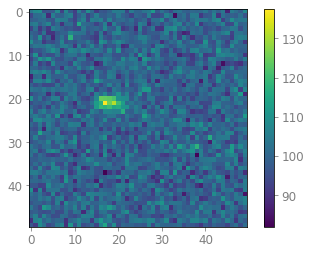

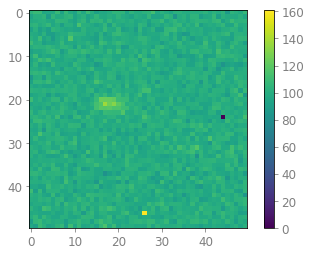

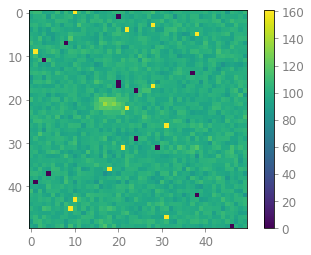

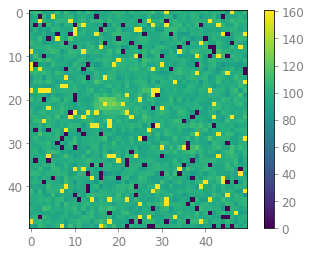

In [0]:
images = classifier.images
for i in [0, 0.0001, 0.01, 0.1]:
  ratio = 0.5
  prob = i
  sp_test = np.copy(images)
  salt = np.ceil(prob * ratio * images[0].size)
  pepper = np.ceil(prob * (1-ratio) * images[0].size)

  for i in range(int(salt)):
    loc = np.random.randint(0, images.shape[2], size=(images.shape[0], 2))
    sp_test[np.arange(images.shape[0]),loc[:,0], loc[:,1]] = images.max()
    
  for j in range(int(pepper)):
    loc = np.random.randint(0, images.shape[2], size=(images.shape[0], 2))
    sp_test[np.arange(images.shape[0]),loc[:,0], loc[:,1]] = 0

  plt.imshow(sp_test[0,:,:,0])
  plt.colorbar()
  plt.show()

In [62]:
prob_list = np.linspace(0, 0.1, 100)
report_list = []
for i in range(len(prob_list)):
  classifier.apply_attack(classifier.add_sp_noise, prob=prob_list[i], ratio=0.5)\
                                    .pre_proc_images(attacked=True)\
                                    .one_hot_encode_labels(attacked=True)\
                                    .evaluate_attack(table=False, confusion_matrix=False)

  report_list.append(classifier.report_dict)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


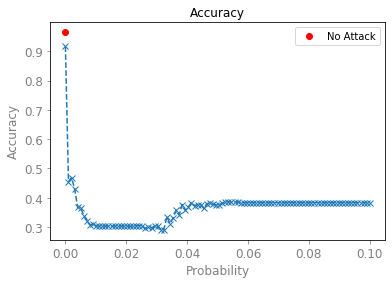

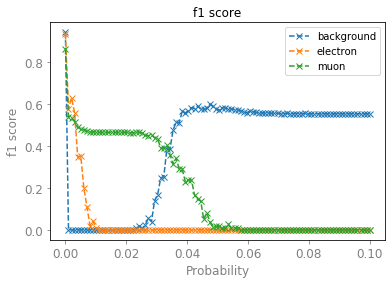

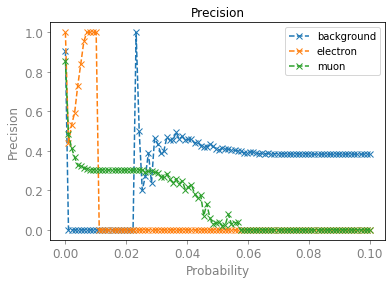

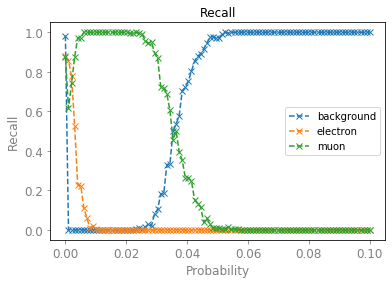

In [63]:
plots(prob_list, report_list, x_label = 'Probability')

muon-background: None
electron-muon: None


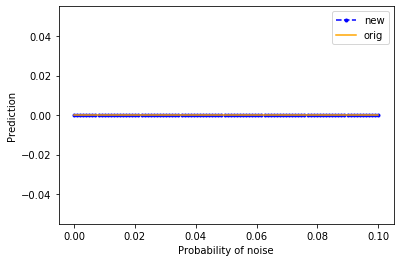

muon-background: 0.06161616161616162
electron-muon: 0.004545454545454545


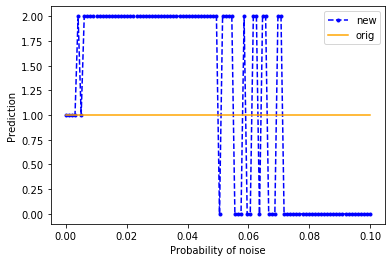

muon-background: None
electron-muon: None


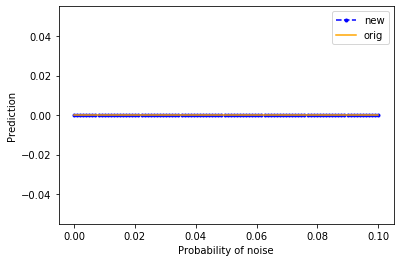

muon-background: None
electron-muon: None


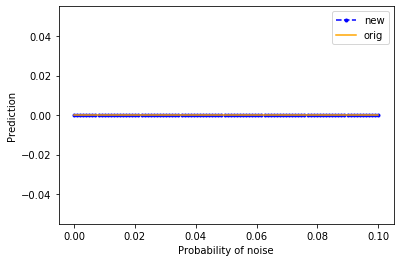

muon-background: 0.05050505050505051
electron-muon: 0.007070707070707071


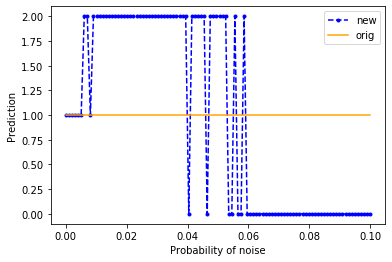

muon-background: 0.031818181818181815
electron-muon: 0.000505050505050505


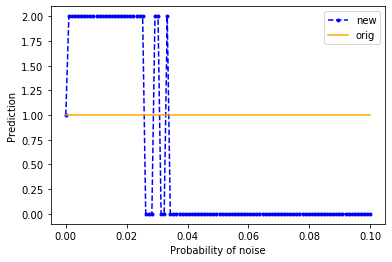

muon-background: 0.03434343434343434
electron-muon: 0.0015151515151515152


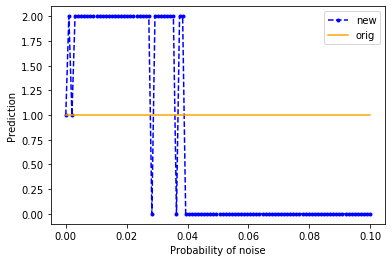

muon-background: 0.011616161616161616
electron-muon: None


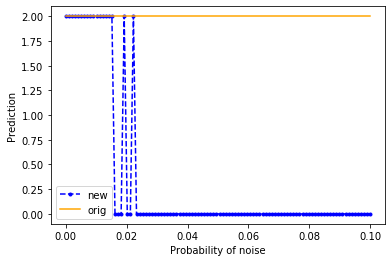

muon-background: None
electron-muon: None


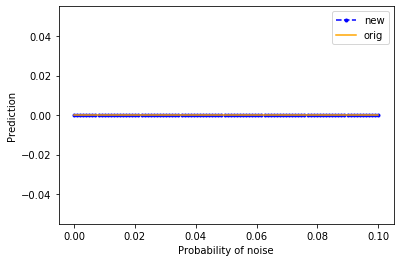

muon-background: 0.03080808080808081
electron-muon: 0.0015151515151515152


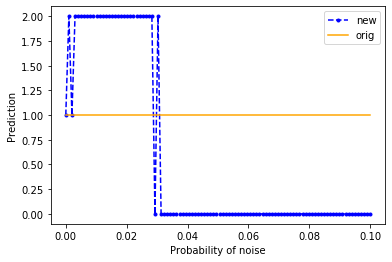

In [0]:
probs = np.linspace(0, 0.1, 100)
old_preds = []
new_preds = []
#n=0
#plt.imshow(classifier.x_test[n,:,:,0])
#plt.show()
muon_cutoffs = []
elec_cutoffs = []

def mb_cutoff(preds):
  if 2 in preds:
    m_b = 0
    b_m = 0
    for i in range(len(preds)):
      if preds[i] == 0 and preds[i-1] == 2:
        m_b = probs[i]
    for j in range(len(preds)-1, -1, -1):
      if preds[j] == 2 and preds[j-1] == 0:
        b_m = probs[j]
    return 0.5*(m_b + b_m)
  else:
    return

def em_cutoff(preds):
  if 1 in preds:
    e_m = 0
    m_e = 0
    for i in range(len(preds)):
      if preds[i] == 1 and preds[i-1] == 2:
        e_m = probs[i]
    for j in range(len(preds)-1, -1, -1):
      if preds[j] == 2 and preds[j-1] == 1:
        m_e = probs[j]
    return 0.5*(e_m + m_e)
  else:
    return

for n in range(0, 10):
  old_preds = []
  new_preds = []
  for k in range(len(probs)):
      prob = probs[k]
      ratio = 0.5
      old_pred = np.argmax(classifier.model.predict(classifier.x_test[n].reshape((1, 50, 50, 1))))
      old_preds.append(old_pred)
      img_copy = classifier.x_test.copy()

      salt = np.ceil(prob * ratio * img_copy[0].size)
      pepper = np.ceil(prob * (1-ratio) * img_copy[0].size)

      for i in range(int(salt)):
        loc = np.random.randint(0, img_copy.shape[2], size=(img_copy.shape[0], 2))
        img_copy[np.arange(img_copy.shape[0]),loc[:,0], loc[:,1]] = img_copy.max()
                
      for j in range(int(pepper)):
        loc = np.random.randint(0, img_copy.shape[2], size=(img_copy.shape[0], 2))
        img_copy[np.arange(img_copy.shape[0]),loc[:,0], loc[:,1]] = 0

      #plt.imshow(img_copy[n,:,:,0])
      #plt.title(prob)
      #plt.show()
      new_pred = np.argmax(classifier.model.predict(img_copy[n].reshape((1, 50, 50, 1))))
      new_preds.append(new_pred)

  if old_pred == 2:
    if mb_cutoff(new_preds) != None:
      muon_cutoffs.append(mb_cutoff(new_preds))
    if em_cutoff(new_preds) != None:
      muon_cutoffs.append(em_cutoff(new_preds))

  if old_pred == 1:
    if mb_cutoff(new_preds) != None:
      elec_cutoffs.append(mb_cutoff(new_preds))
    if em_cutoff(new_preds) != None:
      elec_cutoffs.append(em_cutoff(new_preds))

  print("muon-background:", mb_cutoff(new_preds))
  print("electron-muon:", em_cutoff(new_preds))
  plt.plot(probs, new_preds, '.--',color='b', label='new')
  plt.plot(probs, old_preds, color='orange', label='orig')
  plt.legend()
  plt.xlabel('Probability of noise')
  plt.ylabel('Prediction')
  plt.show()

In [0]:
for n in range(len(classifier.x_test)):
  old_preds = []
  new_preds = []
  for k in range(len(probs)):
      prob = probs[k]
      ratio = 0.5
      old_pred = np.argmax(classifier.model.predict(classifier.x_test[n].reshape((1, 50, 50, 1))))
      old_preds.append(old_pred)
      img_copy = classifier.x_test.copy()

      salt = np.ceil(prob * ratio * img_copy[0].size)
      pepper = np.ceil(prob * (1-ratio) * img_copy[0].size)

      for i in range(int(salt)):
        loc = np.random.randint(0, img_copy.shape[2], size=(img_copy.shape[0], 2))
        img_copy[np.arange(img_copy.shape[0]),loc[:,0], loc[:,1]] = img_copy.max()
                
      for j in range(int(pepper)):
        loc = np.random.randint(0, img_copy.shape[2], size=(img_copy.shape[0], 2))
        img_copy[np.arange(img_copy.shape[0]),loc[:,0], loc[:,1]] = 0

      new_pred = np.argmax(classifier.model.predict(img_copy[n].reshape((1, 50, 50, 1))))
      new_preds.append(new_pred)

  if old_pred == 2:
    if mb_cutoff(new_preds) != None:
      muon_cutoffs.append(mb_cutoff(new_preds))
    if em_cutoff(new_preds) != None:
      muon_cutoffs.append(em_cutoff(new_preds))

  if old_pred == 1:
    if mb_cutoff(new_preds) != None:
      elec_cutoffs.append(mb_cutoff(new_preds))
    if em_cutoff(new_preds) != None:
      elec_cutoffs.append(em_cutoff(new_preds))
      
np.savetxt("muon_cutoffs.txt", muon_cutoffs)
np.savetxt("elec_cutoffs.txt", elec_cutoffs)

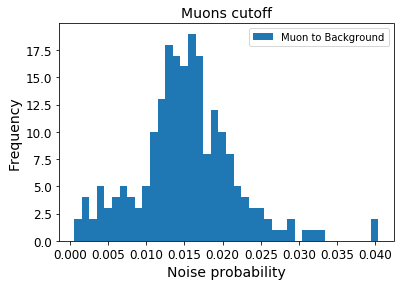

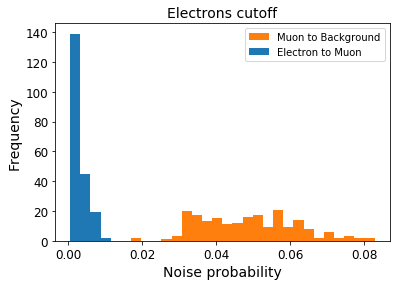

In [87]:
muon_cutoffs = np.loadtxt("/content/drive/My Drive/Year 3/BSc Project/muon_cutoffs.txt")
elec_cutoffs = np.loadtxt("/content/drive/My Drive/Year 3/BSc Project/elec_cutoffs.txt")
elec_cutoffs_etm = []
elec_cutoffs_mtb = []
for i in elec_cutoffs:
  if i > 0.01:
    elec_cutoffs_mtb.append(i)
  else:
    elec_cutoffs_etm.append(i)

plt.hist(muon_cutoffs, bins=40, label="Muon to Background")
plt.title("Muons cutoff", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.xlabel("Noise probability", fontsize=14)
plt.legend()
plt.show()

plt.hist([elec_cutoffs_etm, elec_cutoffs_mtb], bins = 30, histtype='stepfilled',
         label=["Electron to Muon", "Muon to Background"])
plt.title("Electrons cutoff", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.xlabel("Noise probability", fontsize=14)
plt.legend()
plt.show()

In [0]:
classifier = ParticleClassifier()\
                .load_data(path)\
                .train_test_split()\
                .pre_proc_images(train=True, test=True, filters=False)\
                .one_hot_encode_labels(train=True, test=True)\
                .train_model()\
                .evaluate_model()\

Data loaded into self.images, self.labels
Split into self.images_train, self.images_test, self.labels_train, self.labels_test
Train and test labels encoded into self.y_train and self.y_test
Train on 1920 samples, validate on 480 samples
Epoch 1/10
1920/1920 [==============================] - 8s 4ms/sample - loss: 0.6014 - acc: 0.7109 - val_loss: 0.3215 - val_acc: 0.8750
Epoch 2/10
1920/1920 [==============================] - 8s 4ms/sample - loss: 0.2965 - acc: 0.8833 - val_loss: 0.1986 - val_acc: 0.9271
Epoch 3/10
1920/1920 [==============================] - 8s 4ms/sample - loss: 0.2514 - acc: 0.9026 - val_loss: 0.1623 - val_acc: 0.9417
Epoch 4/10
1920/1920 [==============================] - 8s 4ms/sample - loss: 0.1933 - acc: 0.9302 - val_loss: 0.1270 - val_acc: 0.9583
Epoch 5/10
1920/1920 [==============================] - 8s 4ms/sample - loss: 0.1527 - acc: 0.9464 - val_loss: 0.1222 - val_acc: 0.9521
Epoch 6/10
1920/1920 [==============================] - 8s 4ms/sample - loss: 0.144

In [0]:
ratio = 0.9
classifier = ParticleClassifier()\
                .load_data(path)\
                .train_test_split()\
                .pre_proc_images(train=True, test=True, filters=False)\
                .one_hot_encode_labels(train=True, test=True)\
                .train_model()\
                .evaluate_model()\
                .apply_attack(classifier.signal_to_noise, ratio=ratio)\
               .pre_proc_images(attacked=True, filters=False, rescale = False)\
               .one_hot_encode_labels(attacked=True)\
               .evaluate_attack()

Data loaded into self.images, self.labels
Split into self.images_train, self.images_test, self.labels_train, self.labels_test
Train and test labels encoded into self.y_train and self.y_test
Train on 1920 samples, validate on 480 samples
Epoch 1/10
1920/1920 [==============================] - 9s 5ms/sample - loss: 1.4745 - acc: 0.3266 - val_loss: 1.0974 - val_acc: 0.3104
Epoch 2/10
1920/1920 [==============================] - 8s 4ms/sample - loss: 1.1312 - acc: 0.3396 - val_loss: 1.0836 - val_acc: 0.3542
Epoch 3/10
1920/1920 [==============================] - 8s 4ms/sample - loss: 1.0981 - acc: 0.3208 - val_loss: 1.0985 - val_acc: 0.3208
Epoch 4/10
1920/1920 [==============================] - 8s 4ms/sample - loss: 1.0988 - acc: 0.3151 - val_loss: 1.0990 - val_acc: 0.3208
Epoch 5/10
1920/1920 [==============================] - 8s 4ms/sample - loss: 1.0992 - acc: 0.3375 - val_loss: 1.0993 - val_acc: 0.3208
Epoch 6/10
1920/1920 [==============================] - 8s 4ms/sample - loss: 1.053

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       205
           1       0.00      0.00      0.00       197
           2       0.33      1.00      0.50       198

    accuracy                           0.33       600
   macro avg       0.11      0.33      0.17       600
weighted avg       0.11      0.33      0.16       600

Train and test labels encoded into self.y_train and self.y_test
Labels: [205 197 198] 
 Original Predictions: [  0   0 600] 
 Attacked Predictions: [  0   0 600]
              precision    recall  f1-score   support

           2       1.00      1.00      1.00       600

    accuracy                           1.00       600
   macro avg       1.00      1.00      1.00       600
weighted avg       1.00      1.00      1.00       600



In [0]:
ratio = 0.9
classifier = ParticleClassifier()\
                .load_data(path)\
                .train_test_split()\
                .pre_proc_images(train=True, test=True, filters=False, rescale=False)\
                .one_hot_encode_labels(train=True, test=True)\
                .train_model()\
                .apply_attack(classifier.signal_to_noise, ratio=ratio)\
               .pre_proc_images(attacked=True, filters=False, rescale=False)\
               .one_hot_encode_labels(attacked=True)\
               .evaluate_attack()

Data loaded into self.images, self.labels
Split into self.images_train, self.images_test, self.labels_train, self.labels_test
Train and test labels encoded into self.y_train and self.y_test
Train on 1920 samples, validate on 480 samples
Epoch 1/10
1920/1920 [==============================] - 9s 4ms/sample - loss: 1.4085 - acc: 0.3422 - val_loss: 1.0986 - val_acc: 0.3229
Epoch 2/10
1920/1920 [==============================] - 8s 4ms/sample - loss: 1.0987 - acc: 0.3365 - val_loss: 1.0987 - val_acc: 0.3229
Epoch 3/10
1920/1920 [==============================] - 8s 4ms/sample - loss: 1.0987 - acc: 0.3365 - val_loss: 1.0988 - val_acc: 0.3229
Epoch 4/10
1920/1920 [==============================] - 8s 4ms/sample - loss: 1.0987 - acc: 0.3365 - val_loss: 1.0987 - val_acc: 0.3229
Epoch 5/10
1920/1920 [==============================] - 8s 4ms/sample - loss: 1.0988 - acc: 0.3151 - val_loss: 1.0987 - val_acc: 0.3229
Epoch 6/10
1920/1920 [==============================] - 8s 4ms/sample - loss: 1.098

In [0]:
orig_preds = [0, 0, 0]
new_preds = [0, 0, 0]
images = classifier.images
test = images.copy()
ratio = 0.9
for n in range(len(classifier.x_test)):
    old_pred = np.argmax(classifier.model.predict(classifier.x_test[n].reshape((1, 50, 50, 1))))
    if old_pred==0:
      orig_preds[0] += 1
    if old_pred==1:
      orig_preds[1] += 1
    if old_pred==2:
      orig_preds[2] += 1
    test = (classifier.x_test - np.min(classifier.x_test)) * ratio + np.min(classifier.x_test)
    new_pred = np.argmax(classifier.model.predict(test[n].reshape((1, 50, 50, 1))))
    if new_pred==0:
      new_preds[0] += 1
    if new_pred==1:
      new_preds[1] += 1
    if new_pred==2:
      new_preds[2] += 1

print("ratio:", ratio)
print("orig preds:", orig_preds)
print("new preds:", new_preds)

ratio: 0.9
orig preds: [185, 209, 206]
new preds: [126, 234, 240]


In [0]:
orig_preds = [0, 0, 0]
new_preds = [0, 0, 0]
images = classifier.images
test = images.copy()
ratio = 0.8
for n in range(len(classifier.x_test)):
    old_pred = np.argmax(classifier.model.predict(classifier.x_test[n].reshape((1, 50, 50, 1))))
    if old_pred==0:
      orig_preds[0] += 1
    if old_pred==1:
      orig_preds[1] += 1
    if old_pred==2:
      orig_preds[2] += 1
    test = (classifier.x_test - np.min(classifier.x_test)) * ratio + np.min(classifier.x_test)
    new_pred = np.argmax(classifier.model.predict(test[n].reshape((1, 50, 50, 1))))
    if new_pred==0:
      new_preds[0] += 1
    if new_pred==1:
      new_preds[1] += 1
    if new_pred==2:
      new_preds[2] += 1

print("ratio:", ratio)
print("orig preds:", orig_preds)
print("new preds:", new_preds)

ratio: 0.8
orig preds: [185, 209, 206]
new preds: [33, 289, 278]


In [0]:
orig_preds = [0, 0, 0]
new_preds = [0, 0, 0]
images = classifier.images
test = images.copy()
ratio = 0.7
for n in range(len(classifier.x_test)):
    old_pred = np.argmax(classifier.model.predict(classifier.x_test[n].reshape((1, 50, 50, 1))))
    if old_pred==0:
      orig_preds[0] += 1
    if old_pred==1:
      orig_preds[1] += 1
    if old_pred==2:
      orig_preds[2] += 1
    test[n] = (classifier.x_test[n] - np.min(classifier.x_test[n])) * ratio + np.min(classifier.x_test[n])
    new_pred = np.argmax(classifier.model.predict(test[n].reshape((1, 50, 50, 1))))
    if new_pred==0:
      new_preds[0] += 1
    if new_pred==1:
      new_preds[1] += 1
    if new_pred==2:
      new_preds[2] += 1

print("ratio:", ratio)
print("orig preds:", orig_preds)
print("new preds:", new_preds)

ratio: 0.7
orig preds: [185, 209, 206]
new preds: [1, 366, 233]


355.29403734268
7.6338888888888885


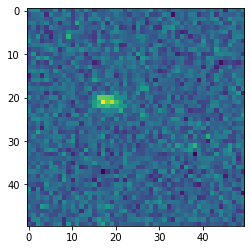

In [0]:
def signaltonoise(a): 
    a = np.ravel(a) 
    m = np.mean(a)
    std = np.std(a)
    return np.where(std == 0, 0, m**2 / std**2) 



images = classifier.images
n=0
print(signaltonoise(images[n]))
print(np.max(images[n])/18)
plt.imshow(images[n,:,:,0])

Poisson noise

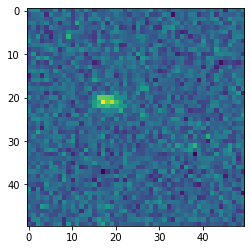

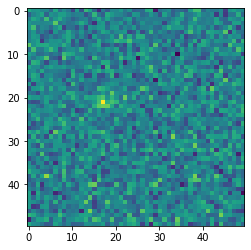

In [0]:
images = classifier.images
poisson_mask = np.random.poisson(100, size=images.shape)
poisson_img = poisson_mask + images
plt.imshow(images[0,:,:,0])
plt.show()
plt.imshow(poisson_img[0,:,:,0])
plt.show()

In [0]:
lambd = 10
classifier = ParticleClassifier()\
                .load_data('toy_data.csv')\
                .train_test_split()\
                .pre_proc_images(train=True, test=True, filters=False)\
                .one_hot_encode_labels(train=True, test=True)\
                .train_model()\
                .evaluate_model()\
                .apply_attack(classifier.add_poisson_noise, lambd=lambd)\
               .pre_proc_images(attacked=True, filters=False)\
               .one_hot_encode_labels(attacked=True)\
               .evaluate_attack()


Data loaded into self.images, self.labels
Split into self.images_train, self.images_test, self.labels_train, self.labels_test
Train and test labels encoded into self.y_train and self.y_test
Train on 1920 samples, validate on 480 samples
Epoch 1/10
1920/1920 [==============================] - 9s 5ms/sample - loss: 0.5851 - acc: 0.7208 - val_loss: 0.4704 - val_acc: 0.8229
Epoch 2/10
1920/1920 [==============================] - 8s 4ms/sample - loss: 0.3249 - acc: 0.8703 - val_loss: 0.4174 - val_acc: 0.8042
Epoch 3/10
1920/1920 [==============================] - 8s 4ms/sample - loss: 0.2765 - acc: 0.8922 - val_loss: 0.2085 - val_acc: 0.9208
Epoch 4/10
1920/1920 [==============================] - 8s 4ms/sample - loss: 0.2148 - acc: 0.9161 - val_loss: 0.1944 - val_acc: 0.9250
Epoch 5/10
1920/1920 [==============================] - 8s 4ms/sample - loss: 0.2452 - acc: 0.9083 - val_loss: 0.1889 - val_acc: 0.9333
Epoch 6/10
1920/1920 [==============================] - 8s 4ms/sample - loss: 0.179

In [0]:
lambd = 30
classifier = ParticleClassifier()\
                .load_data('toy_data.csv')\
                .train_test_split()\
                .pre_proc_images(train=True, test=True, filters=False)\
                .one_hot_encode_labels(train=True, test=True)\
                .train_model()\
                .evaluate_model()\
                .apply_attack(classifier.add_poisson_noise, lambd=lambd)\
               .pre_proc_images(attacked=True, filters=False)\
               .one_hot_encode_labels(attacked=True)\
               .evaluate_attack()

Data loaded into self.images, self.labels
Split into self.images_train, self.images_test, self.labels_train, self.labels_test
Train and test labels encoded into self.y_train and self.y_test
Train on 1920 samples, validate on 480 samples
Epoch 1/10
1920/1920 [==============================] - 9s 5ms/sample - loss: 0.6440 - acc: 0.6583 - val_loss: 0.4530 - val_acc: 0.8104
Epoch 2/10
1920/1920 [==============================] - 8s 4ms/sample - loss: 0.2861 - acc: 0.8766 - val_loss: 0.2055 - val_acc: 0.9229
Epoch 3/10
1920/1920 [==============================] - 8s 4ms/sample - loss: 0.2842 - acc: 0.8891 - val_loss: 0.2278 - val_acc: 0.9104
Epoch 4/10
1920/1920 [==============================] - 8s 4ms/sample - loss: 0.2219 - acc: 0.9208 - val_loss: 0.1968 - val_acc: 0.9271
Epoch 5/10
1920/1920 [==============================] - 8s 4ms/sample - loss: 0.2390 - acc: 0.9130 - val_loss: 0.2615 - val_acc: 0.9146
Epoch 6/10
1920/1920 [==============================] - 8s 4ms/sample - loss: 0.208

In [0]:
lambd = 50
classifier = ParticleClassifier()\
                .load_data('toy_data.csv')\
                .train_test_split()\
                .pre_proc_images(train=True, test=True, filters=False)\
                .one_hot_encode_labels(train=True, test=True)\
                .train_model()\
                .evaluate_model()\
                .apply_attack(classifier.add_poisson_noise, lambd=lambd)\
               .pre_proc_images(attacked=True, filters=False)\
               .one_hot_encode_labels(attacked=True)\
               .evaluate_attack()

Data loaded into self.images, self.labels
Split into self.images_train, self.images_test, self.labels_train, self.labels_test
Train and test labels encoded into self.y_train and self.y_test
Train on 1920 samples, validate on 480 samples
Epoch 1/10
1920/1920 [==============================] - 8s 4ms/sample - loss: 0.5651 - acc: 0.7323 - val_loss: 0.2266 - val_acc: 0.9354
Epoch 2/10
1920/1920 [==============================] - 8s 4ms/sample - loss: 0.2302 - acc: 0.9099 - val_loss: 0.2027 - val_acc: 0.9375
Epoch 3/10
1920/1920 [==============================] - 8s 4ms/sample - loss: 0.1699 - acc: 0.9354 - val_loss: 0.1607 - val_acc: 0.9583
Epoch 4/10
1920/1920 [==============================] - 8s 4ms/sample - loss: 0.1389 - acc: 0.9510 - val_loss: 0.1434 - val_acc: 0.9563
Epoch 5/10
1920/1920 [==============================] - 8s 4ms/sample - loss: 0.1211 - acc: 0.9573 - val_loss: 0.1387 - val_acc: 0.9563
Epoch 6/10
1920/1920 [==============================] - 8s 4ms/sample - loss: 0.112

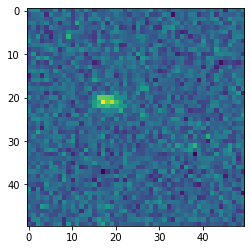

In [0]:
classifier.print_image(0, images)

# Signal to Noise ratio

In [0]:
def signaltonoise(a): 
    a = np.ravel(a) 
    m = np.mean(a)
    std = np.std(a)
    return np.where(std == 0, 0, m / std) 

SNR: 18.963962997898687
orig pred: 0


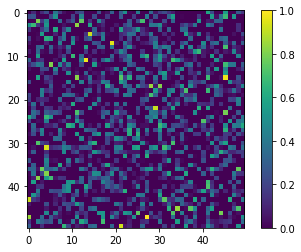

SNR: 0.859527575555448
new pred: 0


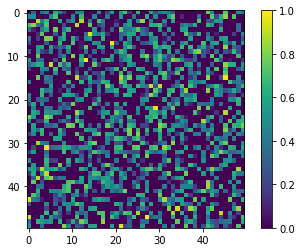

In [0]:
n = 198
images = classifier.images
test = images.copy()
print("SNR:", signaltonoise(test[n]))
old_pred = np.argmax(classifier.model.predict(classifier.x_test[n].reshape((1, 50, 50, 1))))
print("orig pred:", old_pred)
plt.imshow(classifier.x_test[n,:,:,0])
plt.colorbar()
plt.show()
test = classifier.x_test**0.5
print("SNR:", signaltonoise(test[n]))
new_pred = np.argmax(classifier.model.predict(test[n].reshape((1, 50, 50, 1))))
print("new pred:", new_pred)
plt.imshow(test[n,:,:,0])
plt.colorbar()
plt.show()

SNR: 18.963962997898687
orig pred: 1


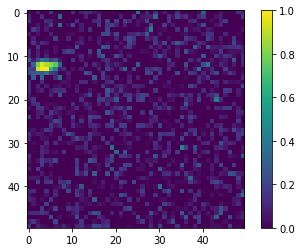

SNR: 0.8418062658501341
new pred: 0


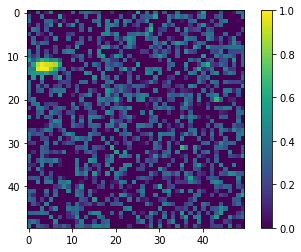

In [0]:
n = 198
images = classifier.images
test = images.copy()
print("SNR:", signaltonoise(test[n]))
old_pred = np.argmax(classifier.model.predict(classifier.x_test[n].reshape((1, 50, 50, 1))))
print("orig pred:", old_pred)
plt.imshow(classifier.x_test[n,:,:,0])
plt.colorbar()
plt.show()
test = classifier.x_test**0.5
print("SNR:", signaltonoise(test[n]))
new_pred = np.argmax(classifier.model.predict(test[n].reshape((1, 50, 50, 1))))
print("new pred:", new_pred)
plt.imshow(test[n,:,:,0])
plt.colorbar()
plt.show()

SNR: 18.77925577592949
orig pred: 1


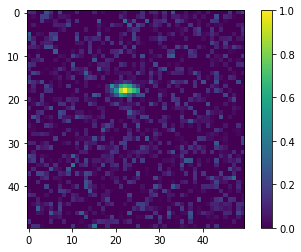

SNR: 0.8353018234302345
new pred: 2


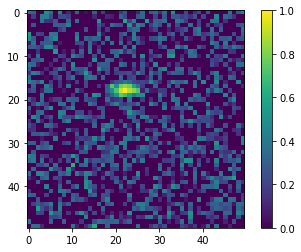

In [0]:
n = 490
images = classifier.images
test = images.copy()
print("SNR:", signaltonoise(test[n]))
old_pred = np.argmax(classifier.model.predict(classifier.x_test[n].reshape((1, 50, 50, 1))))
print("orig pred:", old_pred)
plt.imshow(classifier.x_test[n,:,:,0])
plt.colorbar()
plt.show()
test = classifier.x_test**0.5
print("SNR:", signaltonoise(test[n]))
new_pred = np.argmax(classifier.model.predict(test[n].reshape((1, 50, 50, 1))))
print("new pred:", new_pred)
plt.imshow(test[n,:,:,0])
plt.colorbar()
plt.show()

SNR: 18.779078047748392
orig pred: 2


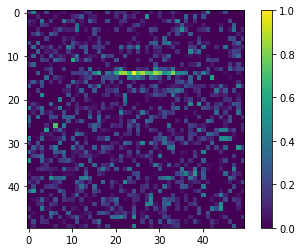

SNR: 0.8482761863587901
new pred: 0


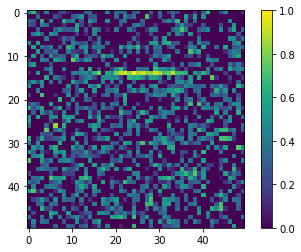

In [0]:
n = 2
images = classifier.images
test = images.copy()
print("SNR:", signaltonoise(test[n]))
old_pred = np.argmax(classifier.model.predict(classifier.x_test[n].reshape((1, 50, 50, 1))))
print("orig pred:", old_pred)
plt.imshow(classifier.x_test[n,:,:,0])
plt.colorbar()
plt.show()
test = classifier.x_test**0.5
print("SNR:", signaltonoise(test[n]))
new_pred = np.argmax(classifier.model.predict(test[n].reshape((1, 50, 50, 1))))
print("new pred:", new_pred)
plt.imshow(test[n,:,:,0])
plt.colorbar()
plt.show()

muon-background: None
electron-muon: None


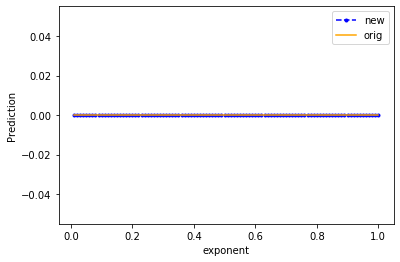

muon-background: 0.7000000000000001
electron-muon: None


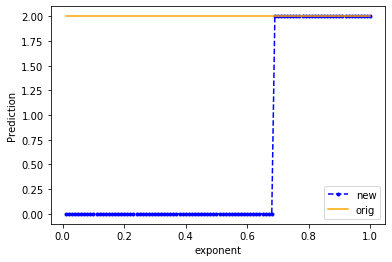

muon-background: 0.8500000000000001
electron-muon: None


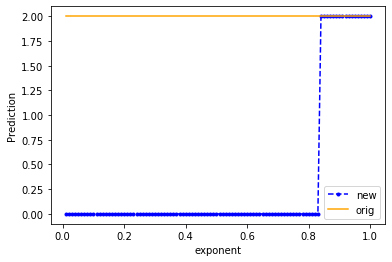

muon-background: 0.64
electron-muon: None


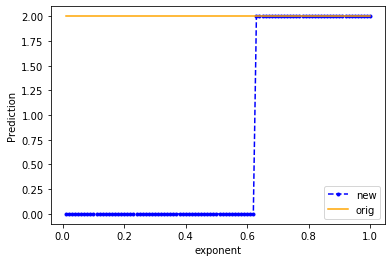

muon-background: 0.68
electron-muon: 0.92


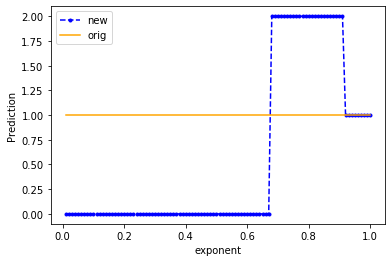

muon-background: 0.5800000000000001
electron-muon: 0.81


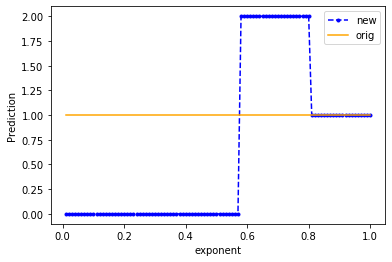

muon-background: 0.88
electron-muon: None


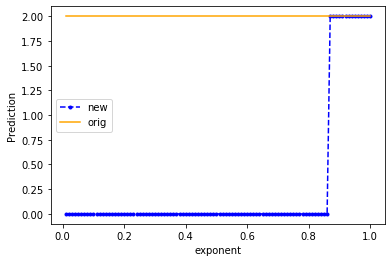

muon-background: 0.7200000000000001
electron-muon: None


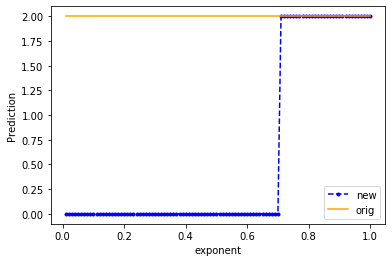

muon-background: 0.64
electron-muon: 0.91


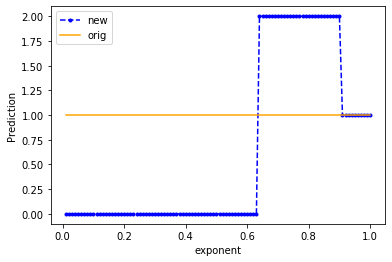

muon-background: 0.66
electron-muon: 0.9500000000000001


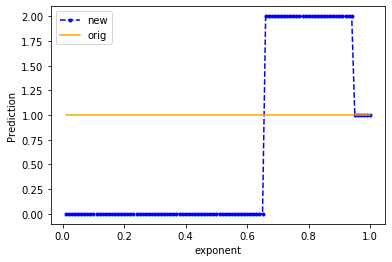

In [0]:
exps = np.linspace(0.01, 1, 100)
old_preds = []
new_preds = []
muon_cutoffs = []
elec_cutoffs = []

def mb_cutoff(preds):
  if 2 in preds:
    m_b = 0
    b_m = 0
    for i in range(len(preds)):
      if preds[i] == 0 and preds[i-1] == 2:
        m_b = exps[i]
    for j in range(len(preds)-1, -1, -1):
      if preds[j] == 2 and preds[j-1] == 0:
        b_m = exps[j]
    return (m_b + b_m)
  else:
    return

def em_cutoff(preds):
  if 1 in preds:
    e_m = 0
    m_e = 0
    for i in range(len(preds)):
      if preds[i] == 1 and preds[i-1] == 2:
        e_m = exps[i]
    for j in range(len(inv_exps)-1, -1, -1):
      if preds[j] == 2 and preds[j-1] == 1:
        m_e = exps[j]
    return (e_m + m_e)
  else:
    return

for n in range(0, 10):
  old_preds = []
  new_preds = []
  for k in range(len(exps)):
      exp = exps[k]
      old_pred = np.argmax(classifier.model.predict(classifier.x_test[n].reshape((1, 50, 50, 1))))
      old_preds.append(old_pred)
      img_copy = classifier.x_test.copy()
      img_copy = np.power(img_copy, exp)

      #plt.imshow(img_copy[n,:,:,0])
      #plt.title(ratio)
      #plt.show()

      new_pred = np.argmax(classifier.model.predict(img_copy[n].reshape((1, 50, 50, 1))))
      new_preds.append(new_pred)

  if old_pred == 2:
    if mb_cutoff(new_preds) != None:
      muon_cutoffs.append(mb_cutoff(new_preds))
    if em_cutoff(new_preds) != None:
      muon_cutoffs.append(em_cutoff(new_preds))

  if old_pred == 1:
    if mb_cutoff(new_preds) != None:
      elec_cutoffs.append(mb_cutoff(new_preds))
    if em_cutoff(new_preds) != None:
      elec_cutoffs.append(em_cutoff(new_preds))

  print("muon-background:", mb_cutoff(new_preds))
  print("electron-muon:", em_cutoff(new_preds))
  plt.plot(exps, new_preds, '.--',color='b', label='new')
  plt.plot(exps, old_preds, color='orange', label='orig')
  plt.legend()
  plt.xlabel('exponent')
  plt.ylabel('Prediction')
  plt.show()

In [0]:
exps = np.linspace(0.01, 1, 100)
muon_cutoffs_stn = []
elec_cutoffs_stn = []
for n in range(len(classifier.x_test)):
  old_preds = []
  new_preds = []
  for k in range(len(ratios)):
      exp = exps[k]
      old_pred = np.argmax(classifier.model.predict(classifier.x_test[n].reshape((1, 50, 50, 1))))
      old_preds.append(old_pred)
      img_copy = classifier.x_test.copy()
      img_copy = np.power(img_copy, exp)

      new_pred = np.argmax(classifier.model.predict(img_copy[n].reshape((1, 50, 50, 1))))
      new_preds.append(new_pred)

  if old_pred == 2:
    if mb_cutoff(new_preds) != None:
      muon_cutoffs_stn.append(mb_cutoff(new_preds))
    if em_cutoff(new_preds) != None:
      muon_cutoffs_stn.append(em_cutoff(new_preds))

  if old_pred == 1:
    if mb_cutoff(new_preds) != None:
      elec_cutoffs_stn.append(mb_cutoff(new_preds))
    if em_cutoff(new_preds) != None:
      elec_cutoffs_stn.append(em_cutoff(new_preds))
      
np.savetxt("/content/drive/My Drive/Year 3/BSc Project/muon_cutoffs_stn.txt", muon_cutoffs_stn)
np.savetxt("/content/drive/My Drive/Year 3/BSc Project/elec_cutoffs_stn.txt", elec_cutoffs_stn)

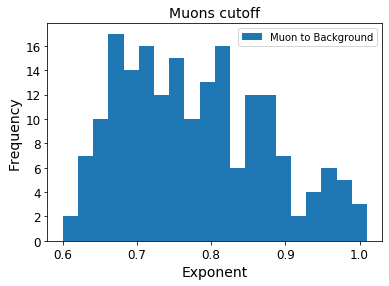

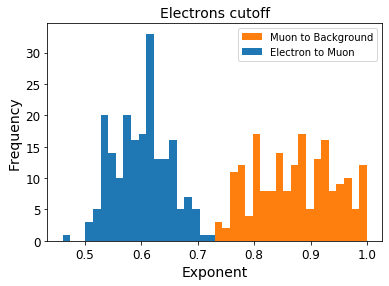

In [96]:
muon_cutoffs_stn = np.loadtxt("/content/drive/My Drive/Year 3/BSc Project/muon_cutoffs_stn.txt")
elec_cutoffs_stn = np.loadtxt("/content/drive/My Drive/Year 3/BSc Project/elec_cutoffs_stn.txt")
elec_cutoffs_stn_etm = []
elec_cutoffs_stn_mtb = []
for i in elec_cutoffs_stn:
  if i > 0.72:
    elec_cutoffs_stn_mtb.append(i)
  else:
    elec_cutoffs_stn_etm.append(i)

plt.hist(muon_cutoffs_stn, bins=20, label="Muon to Background")
plt.title("Muons cutoff", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.xlabel("Exponent", fontsize=14)
plt.legend()
plt.show()

plt.hist([elec_cutoffs_stn_etm, elec_cutoffs_stn_mtb], bins=40, histtype="stepfilled", label=["Electron to Muon", "Muon to Background"])
plt.title("Electrons cutoff", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.xlabel("Exponent", fontsize=14)
plt.legend()
plt.show()